# Data Science Workshop Project
**Team:** Elad Bilman, Oz Hizkia, Eva Hallermeier, Tzach Cohen

**Problem:** The prediction of in-hospital mortality for admitted patients remain poorly characterized and is biased by
             Doctor's opinion.

**Goal of the project**: We aimed to develop and validate a prediction model for all-cause in-hospital mortality among
                         admitted patients.

## Part 1 - Prologue
### Dataset: Patient Survival Prediction

We choose a dataset from Kaggle  https://www.kaggle.com/datasets/mitishaagarwal/patient

This dataset is a collection of patients that visited the ICU in an hospital. <br>Each row represents a patient,which in itself is a collection of checkups of the patient one hour after his reception and one day after his reception, among other medical examinations. <br>The data also includes the basic characteristics of the patient such as gender, ethnicity, etc.



#### Import Modules, Libraries and Functions

In [3]:
%matplotlib inline

# Data Processing
import pandas as pd
import numpy as np

# Machine Learning Library
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Analyze Model Tools
import shap
from sklearn.metrics import confusion_matrix

# Visualization Tools
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from DataprocessingMethods import *
from Model.FinalModel import FinalModel
from Model.ModelModule import DSWorkshopModel
from MissingValuesVisualization import *

# QOL Functions
from UsefullFunctions import load_dataset
from UsefullFunctions import conf_matrix
from UsefullFunctions import plotPR
from UsefullFunctions import plotRoc

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Load Original Dataset
df = load_dataset()
df.head() # Overview of the dataset.

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


The dataset is composed of 85 columns (features) and we have 91,713 patients. <br> 
We can see that we have an entire empty column (index=83) that we will remove.

## Part 2 - Understanding The Dataset

We have different types of feature: numerical, categorical and binary. Some of the features are data about <br> the medical measures of the patient and some are description of hospital unit and cares he received. <br>

<span style='background:#c2f0ee;color:Black'>
In addition, we wrote a complete file which explains all medical features.
</span>

In [5]:
categorial_features = ["hospital_id", "ethnicity", "gender", "icu_admit_source", 
                       "apache_3j_bodysystem", "apache_2_bodysystem", "icu_stay_type", "icu_type"]

numerical_features = ["age", "bmi","height", "weight", 
                      "pre_icu_los_days", "gcs_eyes_apache","apache_2_diagnosis",
                      "gcs_motor_apache", "gcs_verbal_apache", "heart_rate_apache",
                     "map_apache", "resprate_apache", "temp_apache", "d1_diasbp_max",
                      "d1_diasbp_min","d1_diasbp_noninvasive_max", "d1_diasbp_noninvasive_min",
                      "d1_heartrate_max", "d1_heartrate_min", "d1_mbp_max", "d1_mbp_min", 
                      "d1_mbp_noninvasive_max", "d1_mbp_noninvasive_min", "d1_resprate_max", 
                      "d1_resprate_min","d1_spo2_max", "d1_spo2_min", "d1_sysbp_max", "d1_sysbp_min",
                      "d1_sysbp_noninvasive_max", "d1_sysbp_noninvasive_min", "d1_temp_max", 
                      "d1_temp_min","h1_diasbp_max", "h1_diasbp_min", "h1_diasbp_noninvasive_max", 
                      "h1_diasbp_noninvasive_min","h1_heartrate_max", "h1_heartrate_min", 
                      "h1_mbp_max", "h1_mbp_min","h1_mbp_noninvasive_max", "h1_mbp_noninvasive_min",
                      "h1_resprate_max", "h1_resprate_min","h1_spo2_max", "h1_spo2_min", 
                      "h1_sysbp_max", "h1_sysbp_min","h1_sysbp_noninvasive_max", 
                      "h1_sysbp_noninvasive_min", "d1_glucose_max", "d1_glucose_min",
                      "d1_potassium_max", "d1_potassium_min", "apache_4a_hospital_death_prob", 
                      "apache_4a_icu_death_prob","apache_3j_diagnosis"]


binary_features = ["arf_apache", "gcs_unable_apache", "intubated_apache", 
                   "ventilated_apache", "elective_surgery", "apache_post_operative",
                   "aids", "cirrhosis", "diabetes_mellitus", "hepatic_failure", "immunosuppression",
                   "leukemia", "lymphoma", "solid_tumor_with_metastasis"]

### Part 2.1 - The Problem

**Explanation about the Prediction Problem:** <br>
We chose to classify wether the patient that arrive to the hospital 
- have high risk of death (symboled as 1) or 
- low risk of death (symboled as 0), 

This information is written in the original dataset as the feature "hospital_death".<br> This prediction will be based from all data we got from the dataset (medical information collected by the hospital).

So our problem is binary classification.
Build this model can help doctors to choose adapted cares, decisions and medication to save / treat the patient. If a given patient has high risk of death maybe we will choose more intensive care and attention to him.

### Part 2.2 - Thankfully Unbalanced Dataset

([<matplotlib.patches.Wedge at 0x2895d387430>,
 [Text(-1.0598172020063896, 0.294597179774939, '0'),
  Text(1.0598172295885635, -0.2945970805476902, '1')],
 [Text(-0.5780821101853033, 0.16068937078633036, '91.4%'),
  Text(0.5780821252301255, -0.16068931666237643, '8.6%')])

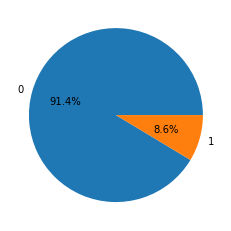

In [6]:
class_prediction = "hospital_death"
unique_labels = np.unique(df[class_prediction])
plt.pie(np.array([len(df[df[class_prediction]==label]) for label in unique_labels]), 
        labels = list(unique_labels), autopct='%1.1f%%')

As we can see, the difference in quantity of the two classes is exceptionally large, <br>
with the label '1' being far less common. <br>
Due to that, it will be a challenge for the model to predict the label '1', which represents cases that ended <br>
with patients' death.

As such we face the challenge of keeping the model from being biased, since most of the data is labeled with '0' <br>
which will cause the model to easily predict this label, but not the other.

## Part 3 - Sanitizing and Organizing the Dataset
### Part 3.1 - Missing Data

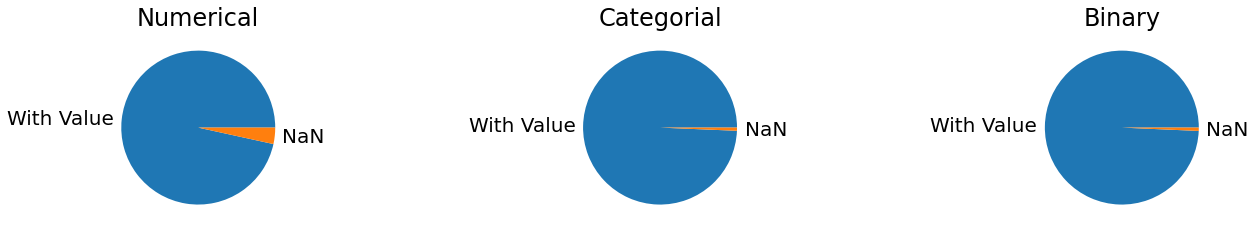

In [7]:
visualizeMissingValues(df)

We divided all features by type : numerical, categorical and binary and we wanted to check the quantity of missing values for those different type. We wanted to check this because we need to fill thoses values in different way depends on the type.

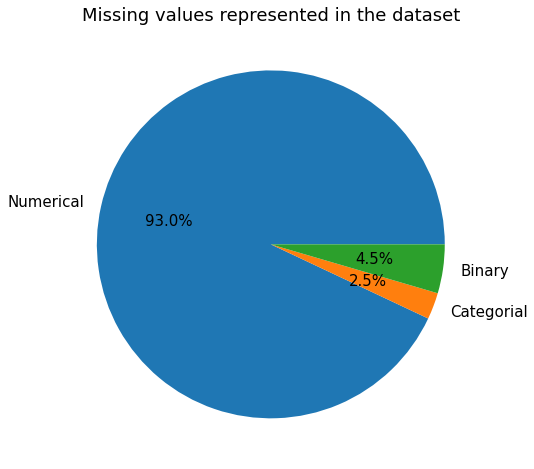

In [8]:
missingValuesDistribution(df)

<span style='background:#ffd500;color:Black'> Most of missing values are numerical. </span>


In [9]:
df.drop(df.columns[[0,1,83]], axis=1, inplace=True) # Remove useless column

We remove those features because :
   - 83 is empty column
   -  0 is encounter id which is not a useful information and have unique value for each patient so it doesn t add any information
   -  1 is patient id which is also unique for each patient so we don t need it for our model
In addition, we compute percentage of missing values for each feature and here is it results: 

We show here list of features which have the highest percent of missing values.

In [10]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
featuresWithManyMissingValues = missing_value_df.sort_values(by='percent_missing',ascending=False).head(25)
featuresWithManyMissingValues.head(15)

,column_name,percent_missing
d1_potassium_max,d1_potassium_max,10.451081
d1_potassium_min,d1_potassium_min,10.451081
h1_mbp_noninvasive_min,h1_mbp_noninvasive_min,9.904812
h1_mbp_noninvasive_max,h1_mbp_noninvasive_max,9.904812
apache_4a_hospital_death_prob,apache_4a_hospital_death_prob,8.665075
apache_4a_icu_death_prob,apache_4a_icu_death_prob,8.665075
h1_diasbp_noninvasive_min,h1_diasbp_noninvasive_min,8.014131
h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_max,8.014131
h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_max,8.004318
h1_sysbp_noninvasive_min,h1_sysbp_noninvasive_min,8.004318


### Part 3.2 - Deal With Missing Values:

We decided to keep all the dataset and filling missing values in this way:
- For Categorical values:
    - We will do one hot encoding so we would not need to deal with missing values. <br>
- For Numerical values:
    - We will fill the cells with the mean of the feature taken <span style='color: #ff0000'> ONLY </span> from the train.
- For Binary values: 
    - We will fill missing values with 0 because most of binary values tell if a patient was given a specific treatment or has a given disease or problem, we will assume that if its not written that it hasn't happened.

## Part 4 - Informative Data Visualization

### Part 4.1 Feature Distribution

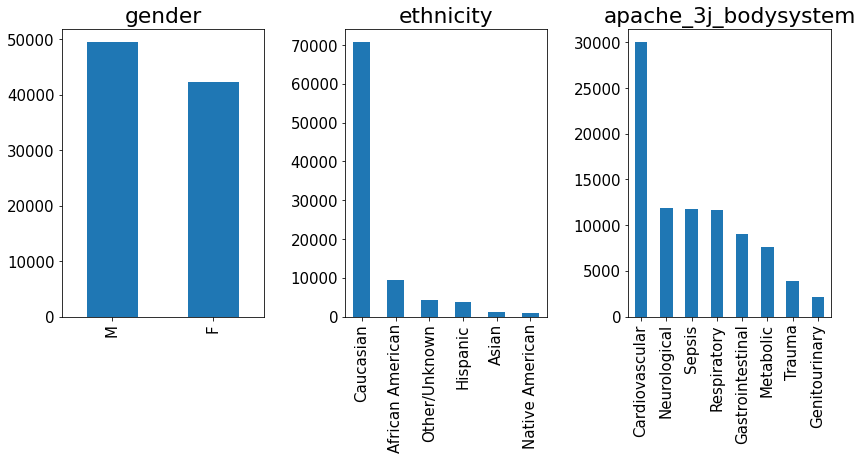

In [11]:
# Histograms of interesting categorical feature: gender, ethnicity and admission diagnosis (type of health problem)

columns =  ["gender", "ethnicity","apache_3j_bodysystem"]
fig, axes = plt.subplots(1,3,figsize=(12,5))

n=len(columns)
num_rows = 1
max_bars = 8

for i,variable in enumerate(columns):
    u=min(df[variable].nunique(),max_bars)
    vc = df[variable].value_counts()[:u]
    plt.rcParams.update({'font.size': 18})
    vc.plot(kind='bar',ax=axes[i],title=variable)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

### Part 4.2 Influence of the Age of the Patient on Hospital Death

We know that older patient have a bigger risk of complications and we can see it clearly on this graph. <br>
The number of deaths is bigger for older patients. <br>
In natural correlation we will also see in the model examination that age is a <b>very</b> important feature.

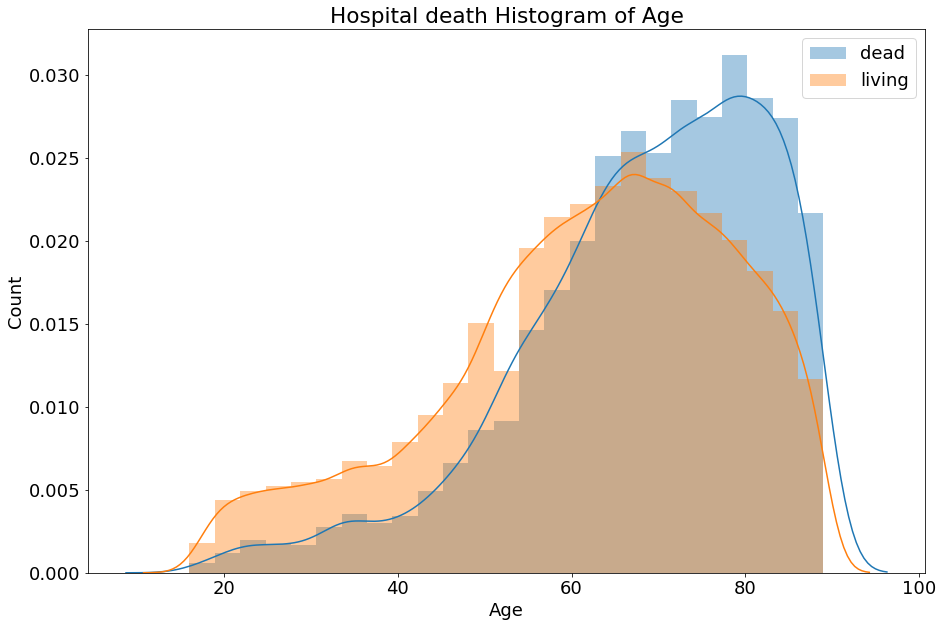

In [12]:
dead_patient = df[df["hospital_death"] == 1]
living_patient = df[df["hospital_death"] == 0]

fig,ax=plt.subplots(figsize=(15,10))

#create two histograms
sns.distplot(dead_patient.age, bins = 25, kde = True, label = "dead",ax=ax)
sns.distplot(living_patient.age, bins = 25, kde = True, label = "living",ax=ax)

plt.title('Hospital death Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(loc="upper right")

## Part 5 - Running Naive Model for Baseline Results and Performance Analysis

### Part 5.1 Executing model

In [13]:
# prepare datset based on our data analysis
df = getBasicDataset()
#prepare data
x_data = df.drop('hospital_death', axis=1) # separate data and target
true_values = df.hospital_death

# split train test
x_train, x_test, y_train, y_test = train_test_split(x_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)

#fill missing values
x_train = fill_missing_num_values_with_mean(x_train)
x_train = fill_missing_values_binary(x_train)
x_test = fill_test_missing_num_values_with_mean(x_test,x_train)
x_test = fill_test_missing_values_binary(x_test, x_train)

all_data = pd.concat([x_train, x_test], axis=0)

We tested a few basic models:
- Random Forest
- Extra Trees
- XGBoost

We got the best result from the XGBoost so we decided to stick with it for our advanced model.
<br>Here the basic results:

In [14]:
#init model
model = DSWorkshopModel(df) 
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

#train mondel
model.train()

#test model
models_predictions, pred_results = model.test()

#results
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0  XGBClassifier         0.695373      0.341756   0.45828   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.930273                 0.663808   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.34176                  0.98586                   47.95s  


**Because we have an unbalanced model we will use "Recall" as our "guiding" metric.  <br>
In addition we used the metric "Balanced Accuracy" which is like the Accuracy metric but the skewness of the dataset is taken into account.**

**Result of the basic model as baseline:**
- Recall around (positive accuracy) 34% so many false negative : many case of 1 are predicted as 0
- Precision around  67%
- Global Accuracy 93%
- Balanced accuracy around 65%
- Negative accuracy around 98 % 

Because we have only around 10% of death cases in our dataset it means that if we have 90% accuracy <br>
thus we probably always give 0 as prediction let's, verify it.

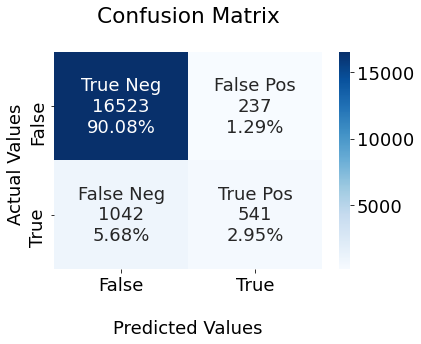

In [15]:
cf_matrix = confusion_matrix(y_test.to_numpy(), models_predictions[-1])
conf_matrix(cf_matrix)

As we predicted the biggest problem is that we have **a lot** of false
negative predictions so our goal will be to reduce it. <br>

<span style='color: #ff0000'> **Important:** </span>
<br>
We decided to predict the "worst" (practicaly increasing the false positives) such that a patient <br> in danger
will receive more attention and intensive care which maybe can save him.

### Part 5.2 - Analyze Performance of the Basic Model
**Precision Recall-Curve:**
Precision-Recall curves should be used for unbalanced dataset.

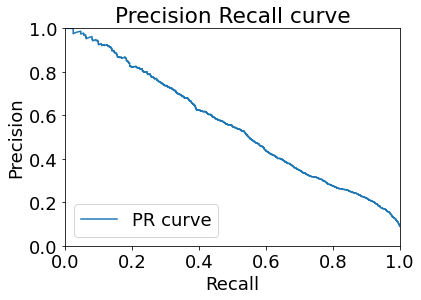

In [16]:
y_true = y_test
xgb = model.get_models()[0] #xgboost
predicted_probs = xgb.predict_proba(x_test)
y_score = predicted_probs[:,1]
    
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
plotPR(precision, recall)

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).


Here we have in the basic model low recall and modest precision.
Notice that as recall increases, precision decreases.

This represents the tradeoff between the two metrics. To increase the recall of our model, the precision must decrease and vice versa.

### Part 5.3 - SHAP Analysis

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


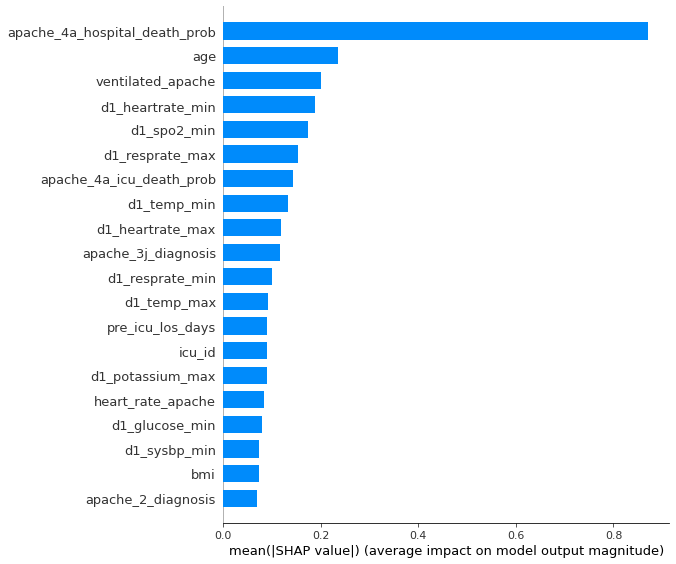

In [17]:
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(all_data)

#feature importance analysis
shap.summary_plot(shap_values, all_data, plot_type="bar")

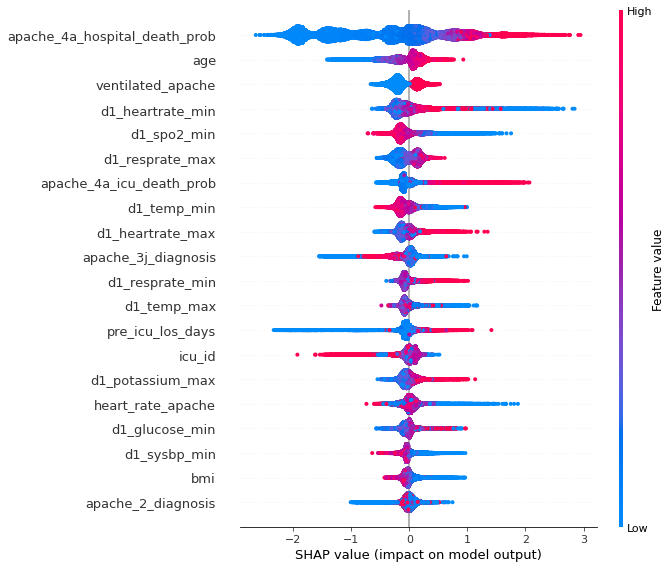

In [18]:
shap.summary_plot(shap_values, all_data)

We can see here clearly here which features have the biggest influence on the prediction of the model.
- Hospital Death Probability
- Age
- Minimun Heartrate after 1 day
- Ventilated Apache

All of those features makes sense so we want to capitilize on them in the final model.
Also as we saw in the graph age is a core player in the prediction.

## Part 6 - Advanced Model

**Additional experiments that didn t give effective results:**

**BMI**: we saw that in the basic model and in general in medical articles this is an important parameter which have a significant impact on mortality. In the original dataset, bmi was represented as his values (number) and this number is computed based on weight and heigh (features also in the datset). BMI can be divided in groups based on the value:'Severe Thinness', 'Moderate Thinness','Mild Thinness','Normal', 'Overweight','Obese l1',"Obese l2"," Obese l3". We thouth that maybe original representation is not enough understandable for the model (not appears in big top most important features) so we tried to change his representation by categories we describe but we didn t get a better performance. 
    
    
**GCS** : is a measure of different capability based on 3 measure that wew divided as 3 separate feature in the original dataset: doctors make sum of those 3 values and this helps to evaluate mortality risk so based on this explanation we thought w also need to represent the data in this way but we didn t get better results. You can check more about this feature in the doc which explain all medical features.
    

### Part 6.1 - Removing Redundant Features
In our analysis of the model we noticed two highly correlated features:
- apache_4a_hospital_death_prob
- apache_4a_icu_death_prob

Below we see the total number of missing values in each one so we have missing values <br>
for same patients in both of the features. <br>

In [19]:
df[["apache_4a_hospital_death_prob","apache_4a_icu_death_prob"]].dropna().corr()

,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
apache_4a_hospital_death_prob,1.000000,0.878988
apache_4a_icu_death_prob,0.878988,1.000000


In [20]:
poc_dataset = load_dataset()
#they have same quantity of missing values (based on our previous missing value analysis)
#We would like to check if missing values are for same patients
counter = 0

for idx,row in poc_dataset.iterrows():
    if pd.isnull(row["apache_4a_hospital_death_prob"]) and pd.isnull(row["apache_4a_icu_death_prob"]):
        counter+=1

print((counter/poc_dataset.shape[0])*100)

8.665074744038467


Lets now try to check if they have same values or really close:<br>
- if yes we don't need both of them and we will keep only one, the one that will get better performance. 

In [21]:
counter = 0

for idx,row in poc_dataset.iterrows():
    if abs(row["apache_4a_hospital_death_prob"] - row["apache_4a_icu_death_prob"])<0.15:
        counter+=1

print((counter/poc_dataset.shape[0])*100)

85.28234819491239


85% of the values are really close, so it means that we don't really need both of them in the dataset.<br>
In our testing we concluded that <br> we get better performance with <span style='color: #ff0000'>only </span>
"apache_4a_hospital_death_prob"<br> so we will
remove the other feature from our dataset.
Let s preprocessing the dataset for running our new model without this feature

### 6.2 Preprocessing data for new model

In [22]:
# Get Original Dataset
df = getBasicDataset()

# Dropping the feature
df = df.drop('apache_4a_hospital_death_prob', axis=1)

# Drop the classification column.
x_data = df.drop('hospital_death', axis=1)
true_values = df.hospital_death

In [23]:
# Split the dataset into train, test.
x_train, x_test, y_train, y_test = train_test_split(x_data, true_values, test_size=0.2,
    stratify=true_values, shuffle=True)

# Fill missing values.
x_train = fill_missing_num_values_with_mean(x_train)
# Fill missing binary values.
x_train = fill_missing_values_binary(x_train)
# Fill missing values.
x_test = fill_test_missing_num_values_with_mean(x_test,x_train)
# Fill missing binary values.
x_test = fill_test_missing_values_binary(x_test, x_train)

### Part 6.3 - Oversampling: Make the Training Set More Balanced

To deal with the unbalanced data we try few ways:


<br> **First**, we delete randomly patients with target 0 until we get a ratio 55%/45% between the two classes.<br>
This trial gave us a too small dataset for training and as expected the results were not better.


<br> **Secondly**, we duplicate randomly rows with target 1 until ratio 55%/45%.
This manipulation didn't increase the performance of the model because the model learns again and again same samples.


<br>**Finnally**, because those manipulation were not successful, we understand that we need to generate data in smart way.<br> So, we use a library that generate additional data which will build a balanced training set (same quantity for the two classes). The data generated is based on the original rows and were applied noise on them to create additional rows for training. This method is called oversampling and permits the model to train with same quantity of label 0 and 1 to learn better in order to predict more precisely each class. <br>
We use the RandomOverSampler algorithm we pick random lines in the class and generates new ones accordingly. <br>


**Note**: we use this <span style='color: #ff0000'> ONLY </span> on the train.

In [24]:
# Getting the oversample model.
oversample = RandomOverSampler(sampling_strategy='minority')
x_np = x_train.to_numpy()
y_np = y_train.to_numpy()

# Oversampling the train.
x_np, y_np = oversample.fit_resample(x_np, y_np)

# Convert back to pandas
x_train = pd.DataFrame(x_np, columns=x_train.columns)
y_train = pd.Series(y_np, name=y_train.name)

### Part 6.4 - Running the Advanced Model

Important changes about this advanced model:
- Given more punishment for mistakes in prediction of death (class "1"):
    - Another way to deal with the skewness of the dataset. Thus ordering the model to give more weight<br>
    (we got the best result with 6 times more weight) to class "1" we make up for the skewness.<br>
    It can be seen as one mistake in class "1" prediction equals multiple mistakes in class "0".
- Changing the evaluation metric of the model:
    - As we have a specific request to increase the True Positives, we need to change the evaluation of the model<br>
    to our needs.<br> Thus using the "aucpr" evaluation method we tell to model to notice more the Recall and Precision
    metrics.
  

In [25]:
model = FinalModel(df)
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

#train mondel
model.train()

#test model
models_predictions, pred_results = model.test()

#results
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0  XGBClassifier         0.223567      0.840177   0.35316   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.734395                  0.78229   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.84018                   0.7244                   98.23s  


**Result of the advanced model compared to baseline:**
- Recall around (positive accuracy) 81% and was 33% in the basic model!
- Balanced accuracy around 77 % and was around 65% in the basic model!
- Negative accuracy and unbalanced accuracy (normal one) decrease


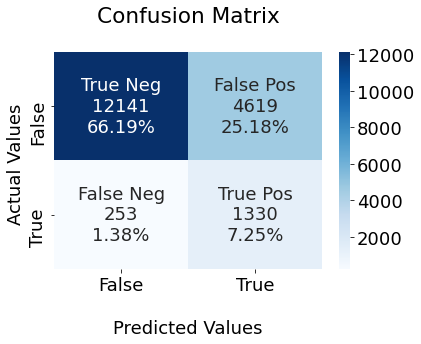

In [26]:
cf_matrix = confusion_matrix(y_test.to_numpy(), models_predictions[-1])
conf_matrix(cf_matrix)

We can say now that we now predict better death cases which was our goal.

### SHAP on the new model

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


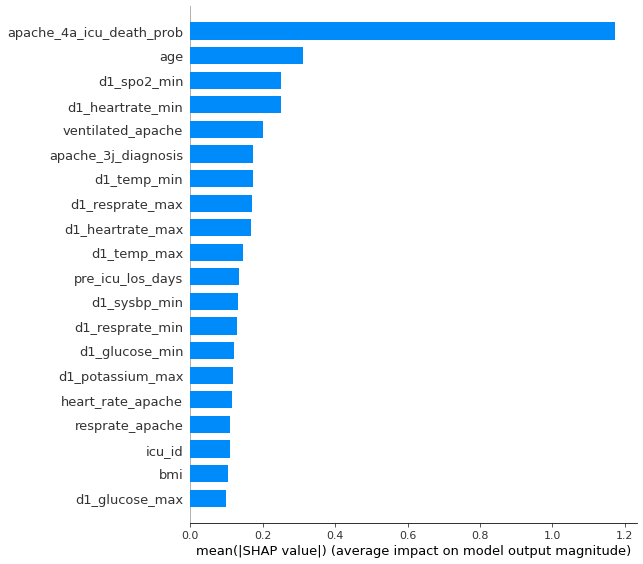

In [28]:
y_true = y_test
all_data = pd.concat([x_train, x_test], axis=0)
xgb = model.get_models()[0] #xgboost
predicted_probs = xgb.predict_proba(x_test)
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(all_data)

#feature importance analysis
shap.summary_plot(shap_values, all_data, plot_type="bar")

## Conclusion

Vital signs are measurements of the body's most basic functions. The four main vital signs routinely monitored by medical professionals and health care providers include the following:

- Body temperature (temp)

- Pulse rate (heart rate)

- Respiration rate (rate of breathing)

- Blood pressure (Blood pressure is not considered a vital sign, but is often measured along with the vital signs.) (sysbp)

Vital signs are useful in detecting or monitoring medical problems. Vital signs can be measured in a medical setting, at home, at the site of a medical emergency, or elsewhere.

All those parameters appepar in the top of most important features of the model which is really logic and means our model use most vital parameters of patients in rder to predict the hospital death target.

In addition age is also an important parameters with bmi.
All those features are usdes for the computation of death prob which is the most important feature of our model.

We built a model which predict death case for admitted patient at hospital. <br> Our model is sensitive and can predict death even if the patient will probably finish alive but it is preferable this way because we don t want to miss patient that can be not treated as they need in order to stay alive.
<br>